In [1]:
import medmnist
from medmnist import INFO, Evaluator

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# data_flag = "dermamnist"
# data_flag = "bloodmnist"
# data_flag = "organamnist"
# data_flag = "organcmnist"
data_flag = "organsmnist"
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
num_channels = info['n_channels']
num_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print(DataClass)

<class 'medmnist.dataset.OrganSMNIST'>


In [39]:
#preprocessing
data_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[.5], std=[.5])
])

#loading
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

#encapsulating
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print(train_dataset)
print("===============")
print(test_dataset)

16529408it [00:18, 877362.56it/s]                               


Using downloaded and verified file: /Users/carlosgil/.medmnist/organsmnist.npz
Dataset OrganSMNIST (organsmnist)
    Number of datapoints: 13940
    Root location: /Users/carlosgil/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 13940, 'val': 2452, 'test': 8829}
    Description: The OrganSMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Sagittal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes 

/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


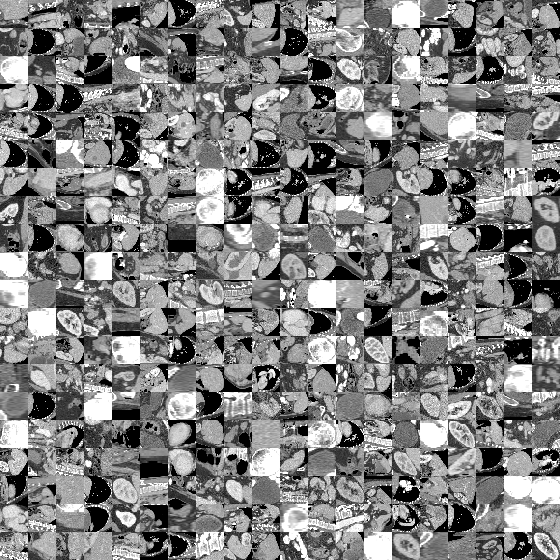

In [40]:
#visualization
train_dataset.montage(length=20)

In [41]:
#Define CNN model

class Net(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(Net, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU()
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(16, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer5 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc = nn.Sequential(
      nn.Linear(64 * 4 * 4, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

model = Net(in_channels=num_channels, num_classes=num_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [42]:
#model
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 109/109 [00:08<00:00, 12.79it/s]


In [43]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.930  acc:0.557
test  auc: 0.903  acc:0.509
